In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))
    
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:5] 
n_proc = 8
rank = 0


In [4]:
%%px

from DataDownload import DataDownload

# Populate velocity field from the Database

if(rank==0):
    print("Starting the loading process")

##########################################
load_from_file = False
store_on_file = True
auth_token = "com.gmail.jhelsas-b854269a"

folder = "/home/admin/scratch"
filename = "aws-isotropic1024coarse-"+str(rank)+"-(t="+str(time)+")"+".npz"
file = folder + "/" + filename

if(load_from_file):
    vx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    vy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    vz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    if(int(content['nproc'])!=nproc):
        print("Unmatched number of processes. Must first pre-process to adequate number of process")
    vx = content['vx']
    vy = content['vy']
    vz = content['vz']
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))
else:
    comm.Barrier(); t1=MPI.Wtime()
    
    ddwnld = DataDownload()
    vx,vy,vz = ddwnld.DownldData_pyJHTDB('isotropic1024coarse',time,nx,ny,nz,nproc,rank,auth_token)
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load field from database: {0:.2f} seconds\n'.format(t2-t1))
    
    comm.Barrier(); t1=MPI.Wtime()
    
    np.savez(file,vx=vx,vy=vy,vz=vz,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))


if(rank==0):
    print("vx shape = "+str(vx.shape))       

CompositeError: one or more exceptions from call to method: execute
[Engine Exception]EngineError: Engine 0 died while running task u'91c2bf02-18f4e534c8f12e8d630e3034'
[Engine Exception]EngineError: Engine 1 died while running task u'41bbe858-af89da05e739f4a65fa5f276'
[Engine Exception]EngineError: Engine 2 died while running task u'964e2a19-3e4fb1b47c4704d4914cfc1b'
[Engine Exception]EngineError: Engine 3 died while running task u'4eb60809-2ae5c8af3e5c726a8d738028'
.... 4 more exceptions ...

In [6]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get wavenumber:
myEnergySpc=EnergySpectrum()
k2,kx,ky,kz=myEnergySpc.GetWavenumbers(nx,ny,nz,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate all wavenumbers: {0:.2f} seconds\n'.format(t2-t1))

[stdout:1] Calculate all wavenumbers: 100.13 seconds


In [7]:
%%px 

comm.Barrier(); t1=MPI.Wtime()

fft = FFT3Dfield_new(nx,ny,nz,nproc,rank)

cvx = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvy = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')
cvz = ft.zeros_aligned((nx,ny,1+(nz//2)), dtype='complex64')

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Alocate FFT : {0:.2f} seconds\n'.format(t2-t1))

[stdout:1] Alocate FFT : 73.55 seconds


In [8]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cvx[:,:,:] = fft.forward3Dfft(vx,nx,ny,nz,nproc,rank)
cvy[:,:,:] = fft.forward3Dfft(vy,nx,ny,nz,nproc,rank)
cvz[:,:,:] = fft.forward3Dfft(vz,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:1] Calculate 3D spatial FFT: 62.78 seconds


In [9]:
%%px
comm.Barrier(); t1=MPI.Wtime()

cwx=np.complex64(0.0+1.0j)*(ky*cvz-kz*cvy)
cwy=np.complex64(0.0+1.0j)*(kx*cvz-kz*cvx)
cwz=np.complex64(0.0+1.0j)*(kx*cvy-ky*cvx)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate vorticity in k space: {0:.2f} seconds\n'.format(t2-t1))

[stdout:1] Calculate vorticity in k space: 217.99 seconds


In [10]:
%%px

wx = ft.zeros_aligned((nx,ny,nz), dtype='float32')
wy = ft.zeros_aligned((nx,ny,nz), dtype='float32')
wz = ft.zeros_aligned((nx,ny,nz), dtype='float32')

In [11]:
%%px 

cwx[kz==(Nz//2)] = 0.
cwy[kz==(Nz//2)] = 0.
cwz[kz==(Nz//2)] = 0.

In [12]:
%%px
comm.Barrier(); t1=MPI.Wtime()
# Get velocity field in Fourier space:


wx[:,:,:]=fft.backward3Dfft(cwx,nx,ny,nz,nproc,rank)
wy[:,:,:]=fft.backward3Dfft(cwy,nx,ny,nz,nproc,rank)
wz[:,:,:]=fft.backward3Dfft(cwz,nx,ny,nz,nproc,rank)

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate 3D spatial inverse FFT: {0:.2f} seconds\n'.format(t2-t1))

[stdout:1] Calculate 3D spatial inverse FFT: 22.09 seconds


In [13]:
%%px

w2 = (wx**2+wy**2+wz**2)

In [14]:
%%px

cacheEnstrophyData = True
loadEnstrophyFromCache = False

folder = "/home/jhelsas/scratch"
filename = "ref-enstrophy-"+str(rank)+".npz"
file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    w2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    w2[:,:,:] = content['w2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,w2=w2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:1] Caching the data: 3.22 seconds


In [15]:
%%px
comm.Barrier(); t1=MPI.Wtime()

avgOmega = np.average(w2)
avgOmegaGl=np.zeros(1,dtype='float32')

comm.Reduce([avgOmega,MPI.REAL],[avgOmegaGl,MPI.REAL],op=MPI.SUM)
avgOmega = avgOmegaGl[0]/nproc
avgOmega = comm.bcast(avgOmega, root=0)

##########################

minw2 = w2.min()
maxw2 = w2.max()

minwGl=np.zeros(nproc,dtype='float32')
maxwGl=np.zeros(nproc,dtype='float32')

comm.Allgather([minw2,MPI.REAL],[minwGl,MPI.REAL])
comm.Allgather([maxw2,MPI.REAL],[maxwGl,MPI.REAL])

minw2 = minwGl.min()
maxw2 = maxwGl.max()

comm.Barrier()

if rank==0:
    print("<w^2> : "+str(avgOmega))
    print("min w2/<w^2> : "+str(minw2/avgOmega))
    print("min w2/<w^2> : "+str(maxw2/avgOmega))

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate average enstrophy: {0:.2f} seconds\n'.format(t2-t1))


[stdout:1] 
<w^2> : 498.43548584
min w2/<w^2> : 1.43997824626e-07
min w2/<w^2> : 675.170001054
Calculate average enstrophy: 0.27 seconds


In [18]:
%%px
w2_bins = np.load('enstrophy_bins.npy')
w2_pdf = np.load('enstrophy_pdf.npy')

Nbins = w2_bins.shape[0]
wtemp = w2[w2<=20*avgOmega] 
w2red=np.zeros(Nbins,dtype='int')
histred,edgesred = np.histogram(wtemp/avgOmega,w2_bins)

In [21]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[w2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

[output:1]

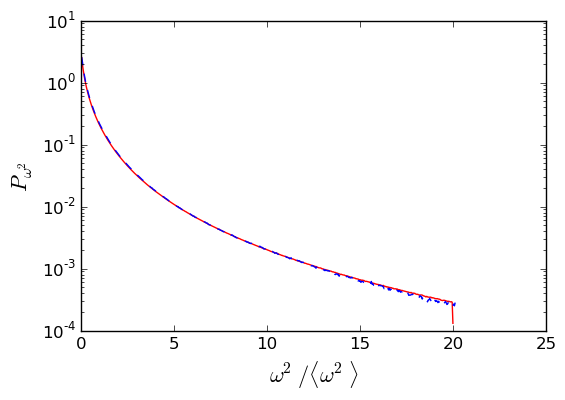

In [22]:
%%px

%matplotlib inline
w2red[-1] = 0
if rank==0:
    w2_bins = np.load('enstrophy_bins.npy')
    w2_pdf = np.load('enstrophy_pdf.npy')
    
    SIZE = 12
    #plt.rc('font', size=SIZE)  # controls default text sizes
    #plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    #plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    #plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    #plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    #plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')
    #plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.semilogy(edgesred,(w2red*(1024**(-3)))/((20*avgOmega-minw2)/(avgOmega*Nbins)),'r',label='Unfiltered')
    plt.semilogy(w2_bins,w2_pdf,'b--')

In [23]:
%%px

sigma2g = avgOmega
Nbins = 1024*8
wtemp = w2[:,:,:] 
w2red=np.zeros(Nbins,dtype='int')
lbins = np.logspace(np.log10(minw2/avgOmega),np.log10(maxw2/avgOmega),Nbins)
histred,edgesred = np.histogram(wtemp/avgOmega,lbins)
#hist,edges = np.histogram(w2/sigma2g,10 ** np.linspace(np.log10(m/sigma2g), np.log10(M/sigma2g), Nbins))

In [24]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[w2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()
    
left = edgesred[0:(Nbins-1)]
right = edgesred[1:Nbins]
normhist = (histred*(1024**(-3)))/(right-left)

if rank==0:
    norm = np.sum(normhist*(right-left))

[output:1]

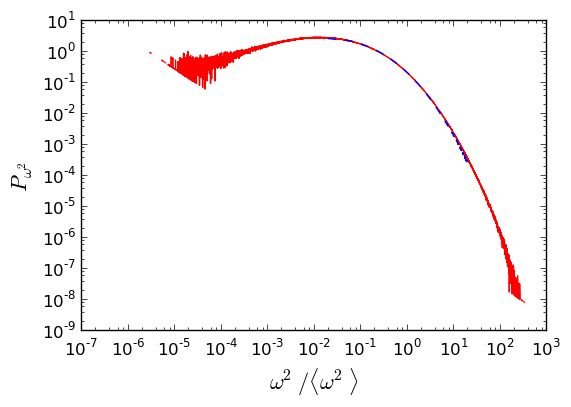

In [26]:
%%px

%matplotlib inline
w2red[-1] = 0
if rank==0:
    w2_bins = np.load('enstrophy_bins.npy')
    w2_pdf = np.load('enstrophy_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')
    #plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.loglog((left+right)/2.,normhist/norm,'r',label='Unfiltered')
    plt.loglog(w2_bins,w2_pdf,'b--')

[output:1]

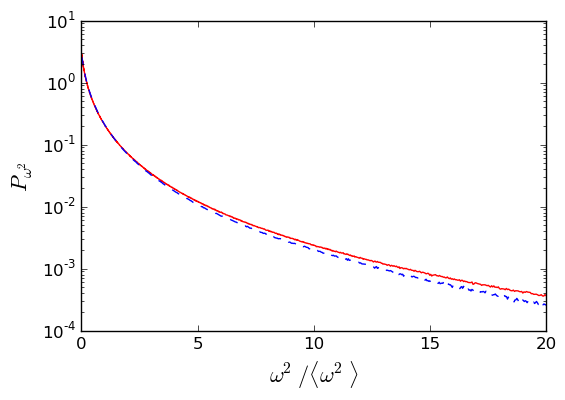

In [28]:
%%px

%matplotlib inline
w2red[-1] = 0
if rank==0:
    w2_bins = np.load('enstrophy_bins.npy')
    w2_pdf = np.load('enstrophy_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')
    plt.xlim(0,20)
    plt.ylim(10**(-4),10**(1))

    plt.semilogy((left+right)/2.,normhist/norm,'r',label='Unfiltered')
    plt.semilogy(w2_bins,w2_pdf,'b--')

In [29]:
%%px
Nbins = 4*1024
wtemp = w2[w2<=20*sigma2g] 
w2red=np.zeros(Nbins,dtype='int')
histred,edgesred = np.histogram(wtemp/sigma2g,np.linspace(minw2/sigma2g, 20, Nbins))
#hist,edges = np.histogram(w2/sigma2g,10 ** np.linspace(np.log10(m/sigma2g), np.log10(M/sigma2g), Nbins))

In [30]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[w2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

[output:1]

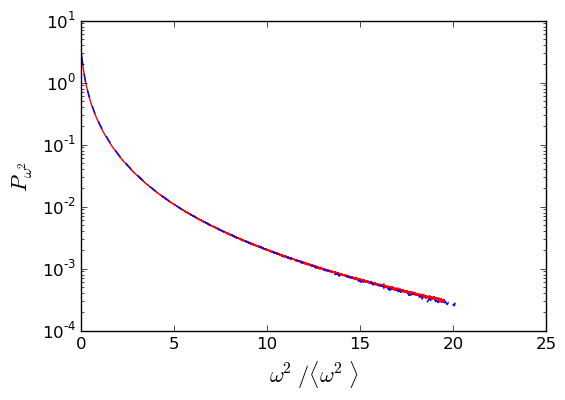

In [32]:
%%px
%matplotlib inline
w2red[-1] = 0
if rank==0:
    w2_bins = np.load('enstrophy_bins.npy')
    w2_pdf = np.load('enstrophy_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    #plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')
    #plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.semilogy(edgesred,(w2red*(1024**(-3)))/((20*sigma2g-minw2)/(sigma2g*Nbins)),'r',label='Unfiltered')
    plt.semilogy(w2_bins,w2_pdf,'b--')